# Qredo tokenomics simulation - Ecosystem fund

### June 2023

## 1. Imports

In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load data

In [18]:
# load
df_file = os.path.join(outfolder, f"sample_by_ecosystem_params_and_scenarios.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released','day_burned',
             "total_staking_rewards", "validators_rewards","ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)

len(df)

9460800

In [19]:
df.columns

Index(['iteration', 'token_scenario', 'usage_scenario', 'staking_scenario',
       'tipping_rate', 'release_rate_max', 'circ_supply', 'day_burned',
       'day_vested', 'day_locked', 'day_released', 'staking_rewards_vested',
       'staking_rewards_ecosystem', 'total_staking_rewards',
       'validators_rewards', 'market_cap', 'n_validators', 'day_burn_fees',
       'day_service_fee_locked', 'ecosystem_fund', 'staking_tvl',
       'year_inflation', 'day_inflation', 'apr', 'tvl_rate',
       'av_validator_reward', 'date'],
      dtype='object')

In [20]:
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]

## 3. Ecosystem fund by scenario

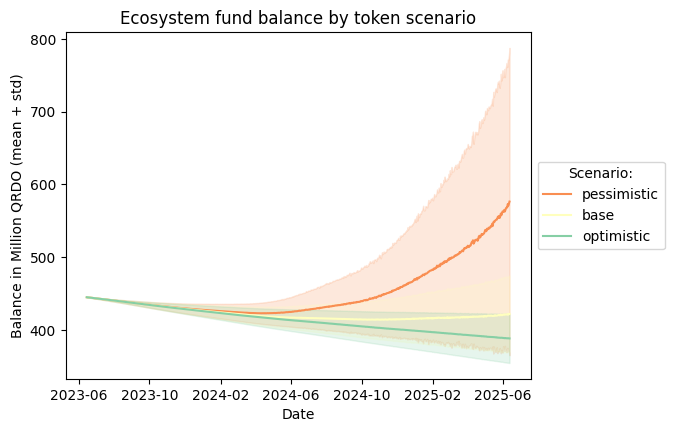

In [8]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.title("Ecosystem fund balance by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

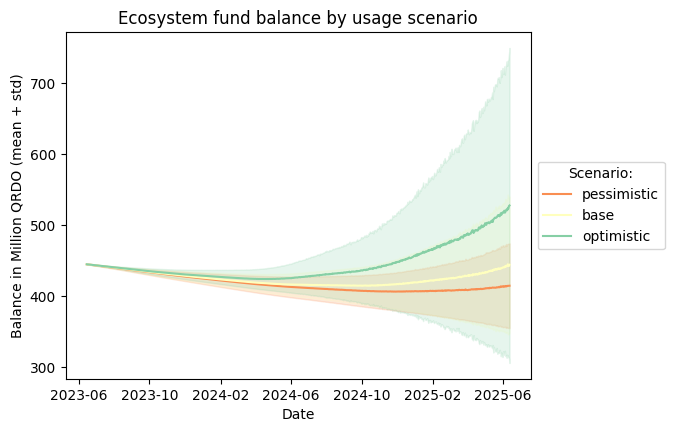

In [9]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.title("Ecosystem fund balance by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

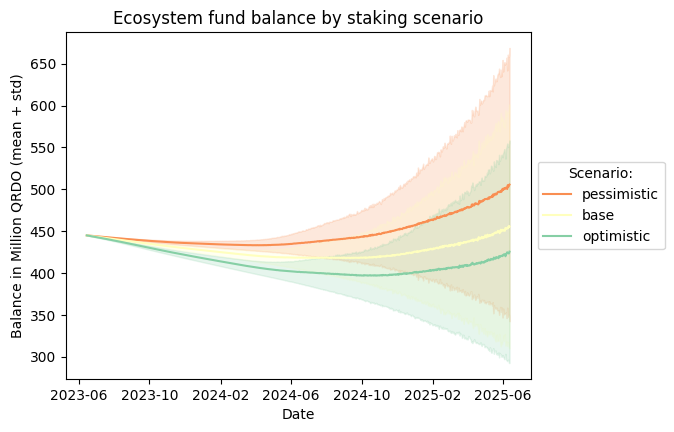

In [10]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.title("Ecosystem fund balance by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

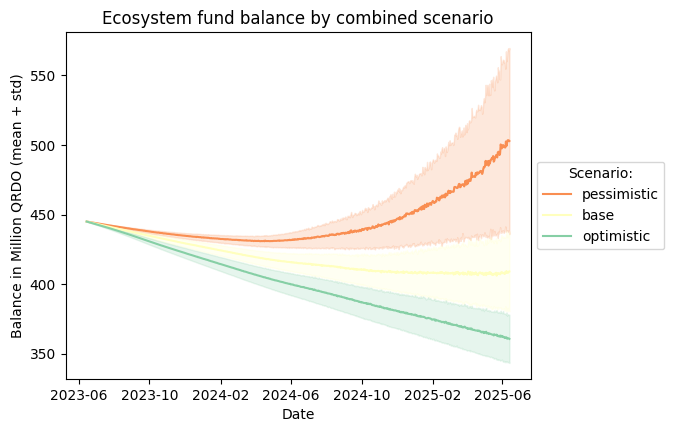

In [11]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.title("Ecosystem fund balance by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## 4. Parameter analysis - max release rate

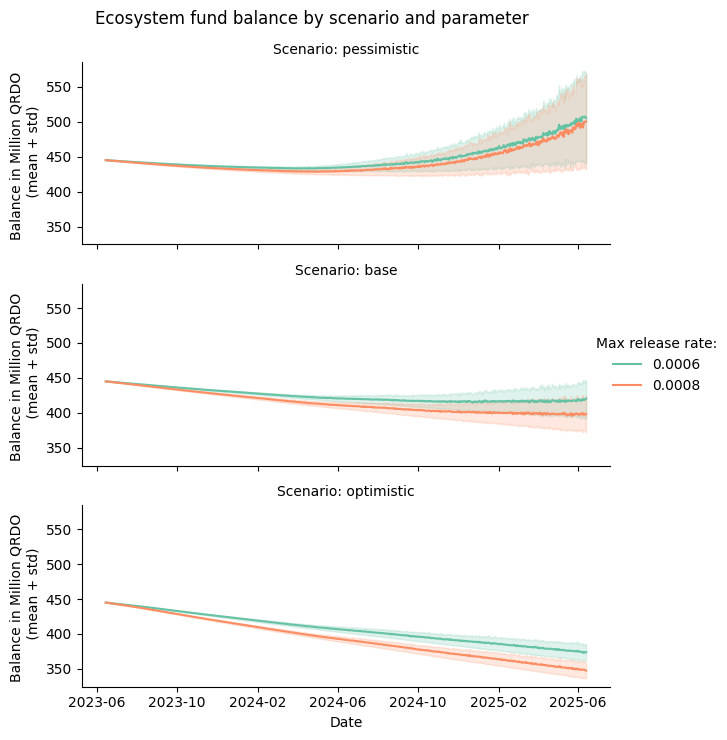

In [16]:
g = sns.relplot(data=combined_df, x="date", y="ecosystem_fund", hue="release_rate_max", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Balance in Million QRDO \n (mean + std)")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Max release rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Ecosystem fund balance by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

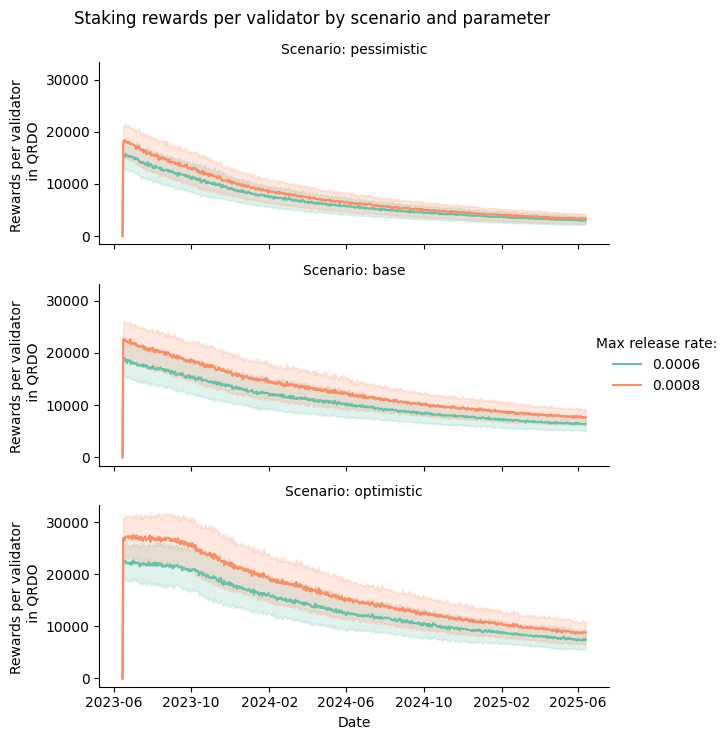

In [23]:
g = sns.relplot(data=combined_df, x="date", y="av_validator_reward", hue="release_rate_max",row="staking_scenario",
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Rewards per validator \n in QRDO")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Max release rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Staking rewards per validator by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

## 5. Parameter analysis - tipping rate

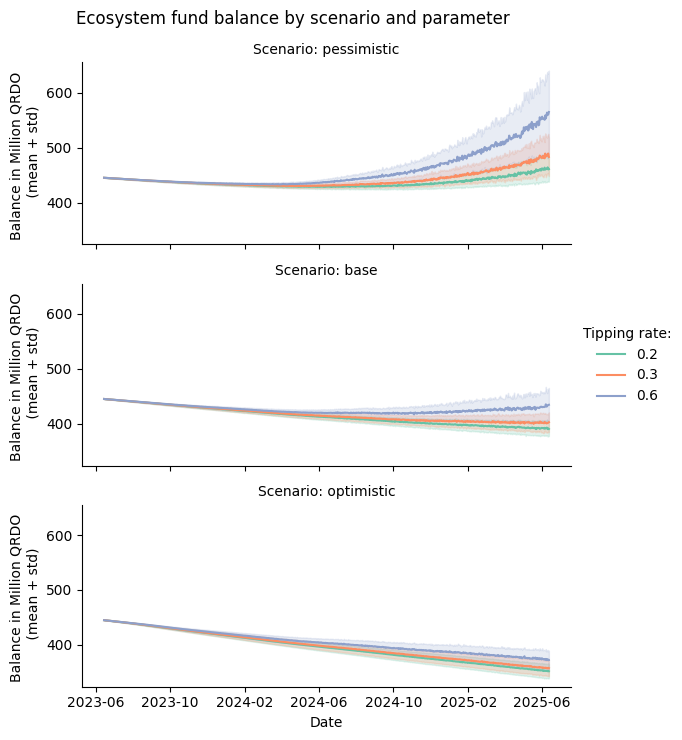

In [17]:
g = sns.relplot(data=combined_df, x="date", y="ecosystem_fund", hue="tipping_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Balance in Million QRDO \n (mean + std)")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Tipping rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Ecosystem fund balance by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

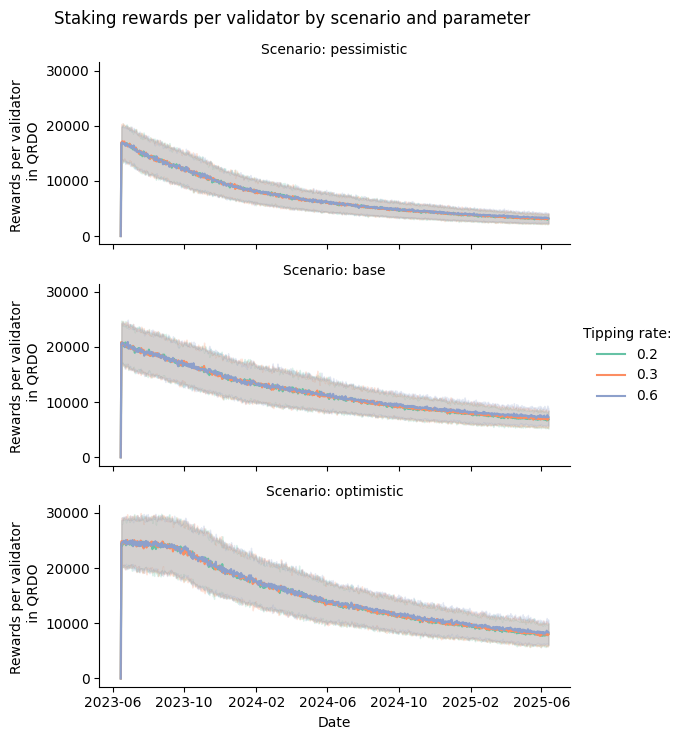

In [24]:
g = sns.relplot(data=combined_df, x="date", y="av_validator_reward", hue="tipping_rate",row="staking_scenario",
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Rewards per validator \n in QRDO")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Tipping rate:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Staking rewards per validator by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()